## 1. 데이터 확인하기

In [1]:
!python prepare_eye_dataset.py

Traceback (most recent call last):
  File "prepare_eye_dataset.py", line 2, in <module>
    import tensorflow as tf
ModuleNotFoundError: No module named 'tensorflow'


In [2]:
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler
from glob import glob

import tensorflow as tf
import numpy as np
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3522063213734780891,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4880930782354155759
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15327420734725287380
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6399838144
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13770888431129792032
 physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [3]:
list_image = sorted(glob('./data/train/input/img/*.png'))
list_label = sorted(glob('./data/train/label/mask/*.png'))
print(len(list_image), len(list_label))

23712 23712


In [4]:
IMAGE_SHAPE = (80, 120)
data_root = './data/train/input'
label_root = './data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

Found 23712 images belonging to 1 classes.
Found 23712 images belonging to 1 classes.


In [5]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1]
        
        list_point_labels = []
        for img, label in zip(images, labels):
            
            eye_ls = np.where(label==1)
            eye_rs = np.where(label==2)
            eye_center = np.where(label==3)
            
            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]
            
            if len(eye_ls[0]) == 0 or len(eye_ls[1]) == 0:
                lx, ly = [0, 0]
            if len(eye_rs[0]) == 0 or len(eye_ls[1]) == 0:
                rx, ry = [w, h]
            if len(eye_center[0]) == 0 or len(eye_center[1]) == 0:
                cx, cy = [0, 0]
                
            np_point_label = np.array([lx/w, ly/h, rx/w, ry/h, cx/w, cy/h], dtype=np.float32)
            
            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

In [6]:
user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print(dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.         0.         1.         1.         0.6092606  0.35483164]
(80, 120, 3) [0.         0.         1.         1.         0.74583334 0.43951613]


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


## 2. 모델 설계하기

In [7]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(80, 120, 3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='sigmoid')
])

model.summary()

(32, 2048)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']
)

In [9]:
def lr_step_decay(epoch):
    init_lr = 0.0005
    lr_decay = 0.5
    epoch_per_decay = 2
    lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch) / epoch_per_decay))
    return lrate

In [10]:
import math

steps_per_epoch = image_data.samples // image_data.batch_size
print(image_data.samples, image_data.batch_size, steps_per_epoch)

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=10, steps_per_epoch = steps_per_epoch, callbacks = [learning_rate])

23712 32 741
Epoch 1/10


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


741/741 [==============================] - 22s 30ms/step - loss: 0.0195 - mae: 0.0685
Epoch 2/10
741/741 [==============================] - 15s 21ms/step - loss: 0.0142 - mae: 0.0561
Epoch 3/10
741/741 [==============================] - 15s 21ms/step - loss: 0.0136 - mae: 0.0543
Epoch 4/10
741/741 [==============================] - 16s 22ms/step - loss: 0.0133 - mae: 0.0533
Epoch 5/10
741/741 [==============================] - 15s 21ms/step - loss: 0.0132 - mae: 0.0530
Epoch 6/10
741/741 [==============================] - 16s 21ms/step - loss: 0.0129 - mae: 0.0525
Epoch 7/10
741/741 [==============================] - 16s 21ms/step - loss: 0.0128 - mae: 0.0522
Epoch 8/10
741/741 [==============================] - 16s 21ms/step - loss: 0.0128 - mae: 0.0521
Epoch 9/10
741/741 [==============================] - 16s 21ms/step - loss: 0.0128 - mae: 0.0520
Epoch 10/10
741/741 [==============================] - 15s 21ms/step - loss: 0.0127 - mae: 0.0518


## 3. 모델 평가하기

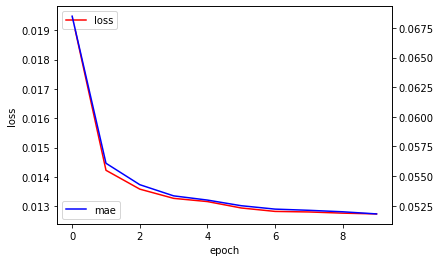

In [12]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'r', label='loss')
acc_ax.plot(history.history['mae'], 'b', label='mae')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

In [13]:
val_data_root = './data/val/input'
val_label_root = './data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()

image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2638 images belonging to 1 classes.
Found 2638 images belonging to 1 classes.


In [14]:
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)

Instructions for updating:
Please use Model.evaluate, which supports generators.


Instructions for updating:
Please use Model.evaluate, which supports generators.
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


0.012625630013644695 0.05166887119412422


(21, 28, 3)


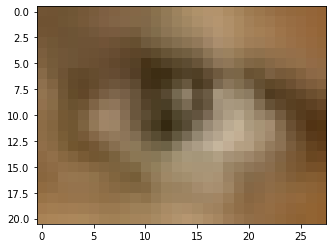

In [35]:
import cv2


img = cv2.imread('./data/val/input/img/eye_007050_r.png')
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [81]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:, :, 0] *= 120
repred[:, :, 1] *= 80
print(repred)

[[[9.28757421e-04 1.65900492e-05]
  [1.19988914e+02 7.99999390e+01]
  [4.61055069e+01 2.41493893e+01]]]


pt:  [4. 4.]
pt:  [26. 18.]
pt:  [12.  8.]


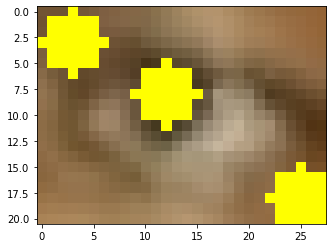

In [82]:
show = img.copy()
for pt in repred[0]:
    pt += 22
    pt *= 0.18
    print('pt: ', pt.round())
    show = cv2.circle(show, tuple((pt).astype(int)), 3, (0, 255, 255), -1)
    
plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()